In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow.keras.backend as K 
import gym
import numpy as np
import random as rand

DQN
=======

In [3]:
class Agent(object):
    def __init__(self):
        # 프로그램 동작 설정
        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0] # cartpole이 가진 state 개수
        self.action_size = self.env.action_space.n # cartpole의 agent가 선택할 수 있는 action의 개수

        # model의 설정
        self.node_num = 12 # nn layer에 들어있는 node의 개수
        self.learning_rate = 0.001
        self.epochs_cnt = 5
        self.model = self.build_model()
        
        # 학습 설정
        self.discount_rate = 0.97
        self.penalty = -100 # 막대가 cartpole에서 떨어져 종료되었을 때 받을 음의 보상의 크기
        
        # 반복 설정 영역 
        self.episode_num = 500 # 몇 번의 episode를 반복하여 data를 수집할 것인가

        # data 수집 환경
        self.replay_memory_limit = 2048
        self.replay_size = 32 # mini batch통해 학습할 데이터의 양을 지정
        self.replay_memory = [] # 수집한 cartpole의 실행 정보가 저장

        # 탐험 환경 설정
        self.epsilon = 0.99
        self.epsilon_decay = 0.2
        self.epsilon_min = 0.05

        # training monitoring
        self.moving_avg_size = 20 # moving average size3
        self.reward_list = []
        self.count_list = [] # 각 episode에서 cartpole이 실행된 횟수
        self.moving_avg_list = []

    def build_model(self): # neural net build
        input_states = Input(shape = (1,self.state_size), name = "input_states") # model : state -> q value for each action
        x = (input_states)
        x = Dense(self.node_num, activation = "relu")(x) # hidden layer의 node 개수
        out_actions = Dense(self.action_size, activation = "linear", name = "output")(x) # output layer = q value per actions
        model = tf.keras.models.Model(inputs = [input_states], outputs = [out_actions])
        model.compile(optimizer = Adam(learning_rate = self.learning_rate), loss = "mean_squared_error")
        model.summary()
        return model
    
    def train(self): # train the model
        for episode in range(self.episode_num): # step : cartpole이 한 번 실행되는 것 // episode : cartpole이 처음 실행되어 종료될 때까지의 전 과정
            state,_ = self.env.reset() # cartpole 실행 환경의 초기화
            Q, count, reward_tot = self.take_action_and_append_memory(episode, state) # 경험을 기록

            if count < 500:
                reward_tot = reward_tot - self.penalty
            
            # 하나의 episode 종료 -> 수집된 보상과 실행 횟수 저장
            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list, self.moving_avg_size))

            # replay memory에 저장된 데이터를 replay_size만큼 가져와서 학습
            self.train_mini_batch(Q)

            # training log
            if (episode%10 == 0 ):
                print("episode : {}, moving_avg : {}, rewards_avg : {}".format(episode, self.moving_avg_list[-1],np.mean(self.reward_list)))
        self.save_model()

    def take_action_and_append_memory(self, episode, state):
        reward_tot = 0
        count = 0
        done = False

        epsilon = self.get_epsilon(episode) # epsilon 계산 w/ decay -> determin whether exploration or exploitation
        while not done: # 반복 설정
            count+=1
            state_t = np.reshape(state, [1,1,self.state_size])
            Q = self.model.predict(state_t,verbose = 0) # Q값을 예측
            action = self.greed_search(epsilon, episode, Q) # action을 선택
            state_next, reward, done, _, _ = self.env.step(action) # 행동을 실행 -> 환경이 다음 state와 reward를 return

            if done: # 막대가 바닥에 떨어진 경우
                reward = self.penalty
            self.replay_memory.append([state_t, action, reward, state_next, done]) # 경험을 replay_memory에 저장
            if len(self.replay_memory)>self.replay_memory_limit: # replay_memory가 너무 커지면 오래된 정보부터 삭제
                del self.replay_memory[0]
            reward_tot += reward
            state = state_next
        return Q, count, reward_tot
    
    def train_mini_batch(self, Q): # train via replay memory
        array_state = []
        array_Q = []
        this_replay_size = self.replay_size # 학습에 사용할 데이터의 크기
        if len(self.replay_memory) < self.replay_size: # 기존에 저장되어 있던 정보보다 작은 양의 정보가 replay_memory에 있는 경우 : exception handling
            this_replay_size = len(self.replay_memory)
        
        for sample in rand.sample(self.replay_memory, this_replay_size): # radom sampling
            state_t, action, reward, state_next, done = sample # training data 분리

            # Q값 계산
            if done : # 게임이 종료된 경우 -> 다음 상태가 없음
                Q[0, 0, action] = reward
            else: # 게임이 종료되지 않은 경우
                state_t = np.reshape(state_next, [1,1,self.state_size])
                Q_new = self.model.predict(state_t, verbose = 0)
                Q[0, 0, action] = reward + self.discount_rate*np.max(Q_new)

            # data shape 변경
            array_state.append(state_t.reshape(1,self.state_size))
            array_Q.append(Q.reshape(1,self.action_size))
        array_state_t = np.array(array_state)
        array_Q_t = np.array(array_Q)

        # model의 학습
        hist = self.model.fit(array_state_t, array_Q_t, epochs = self.epochs_cnt, verbose = 0)

    def get_epsilon(self, episode):
        result = self.epsilon * (1- episode/(self.episode_num*self.epsilon_decay))
        if result < self.epsilon_min:
            result = self.epsilon_min
        return result
    
    def greed_search(self, epsilon, episode, Q) : 
        if epsilon > np.random.rand(1):
            action = self.env.action_space.sample()
        else:
            action = np.argmax(Q)
        return action
    
    def moving_avg(self, data, size = 10):
        if len(data) > size:
            c = np.array(data[len(data) - size: len(data)])
        else:
            c = np.array(data)
        return np.mean(c)
    
    def save_model(self):
        self.model.save("./model/dqn")
        print("****** end learning")

In [48]:
if __name__ == "__main__" : 
    agent = Agent()
    agent.train()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 1, 4)]            0         
                                                                 
 dense_13 (Dense)            (None, 1, 12)             60        
                                                                 
 output (Dense)              (None, 1, 2)              26        
                                                                 
Total params: 86 (344.00 Byte)
Trainable params: 86 (344.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode : 0, moving_avg : 22.0, rewards_avg : 21.0
episode : 10, moving_avg : 26.818181818181817, rewards_avg : 25.818181818181817
episode : 20, moving_avg : 24.35, rewards_avg : 23.238095238095237
episode : 30, moving_avg : 21.9, rewards_avg : 22.64516129032258
episode : 40, moving_avg : 22.2, rewards_avg : 22.24390243902439
episode : 50, moving_avg : 19.25, rewards_avg : 20.92156862745098
episode : 60, moving_avg : 18.6, rewards_avg : 20.721311475409838
episode : 70, moving_avg : 25.8, rewards_avg : 22.014084507042252
episode : 80, moving_avg : 38.0, rewards_avg : 24.74074074074074
episode : 90, moving_avg : 36.1, rewards_avg : 24.89010989010989
episode : 100, moving_avg : 18.6, rewards_avg : 23.326732673267326
episode : 110, moving_avg : 9.95, rewards_avg : 22.01801801801802
episode : 120, moving_avg : 12.05, rewards_avg : 21.297520661157026
episode : 130, moving_avg : 19.9, rewards_avg : 21.541984732824428
episode : 140, moving_avg : 23.95, rewards_avg : 21.53191489361702
episode :

INFO:tensorflow:Assets written to: ./model?dqn/assets


****** end learning


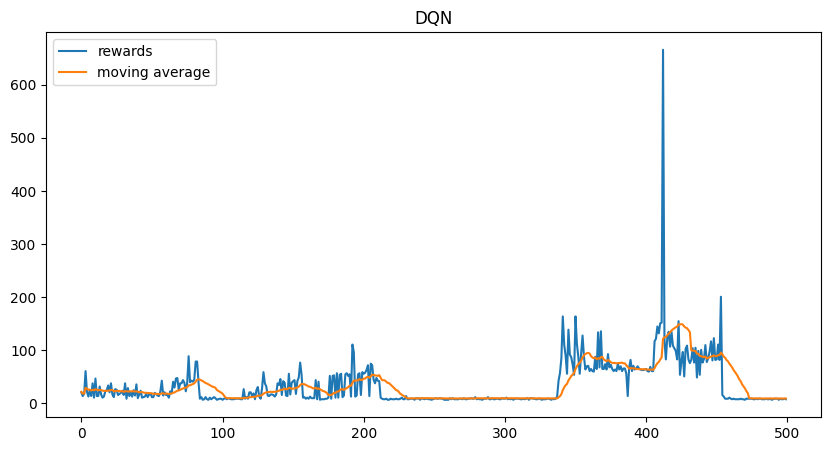

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("DQN")
plt.show()

REINFORCE
========

In [104]:
class Agent(object):
    def __init__(self):
        # 프로그램의 동작 설정
        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1 # 보상값의 크기

        self.node_num = 12
        
        self.learning_rate = 0.0005
        self.epochs_cnt = 5
        self.model = self.build_model()

        self.discount_rate = 0.95
        self.penalty = -10

        self.episode_num = 500

        self.moving_avg_size = 20

        # data 수집 환경
        self. states, self.action_matrices, self.action_probs, self.rewards = [], [], [], []
        self.DUMMY_ACTION_MATRIX, self.DUMMY_REWARD = np.zeros((1,1,self.action_size)), np.zeros((1,1,self.value_size)) # parameter의 개수를 맞춰주기 위함

        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []

    class MyModel(tf.keras.Model):
        def train_step(self, data): # overriding for user defined cost function
            # 입력 변수 설정
            in_datas, out_actions = data
            states, action_matrix, rewards = in_datas[0], in_datas[1], in_datas[2]
            with tf.GradientTape() as tape: # for auto gradient 
                y_pred = self.call(states, training = True) # 행동 예측(좌/우). Note : self는 GradientTape Object
                action_probs = K.sum (action_matrix*y_pred, axis = -1) # 확률 계산 (SoftMax)
                loss = -K.log(action_probs) * rewards
            trainable_vars = self.trainable_variables # Model Class 내부에서 Weight & Bias를 저장

            gradients = tape.gradient(loss, trainable_vars) # gradient calc
            self.optimizer.apply_gradients(zip(gradients, trainable_vars)) # 최적화 알고리즘을 통해 입력된 변수에 대한 gradient 적용
            self.compiled_metrics.update_state(out_actions, y_pred)
            return {m.name: m.result() for m in self.metrics}

    def build_model(self):
        input_states = Input(shape = (1,self.state_size), name = "input_states")
        input_action_matrices = Input(shape = (1,self.action_size), name = "input_action_matrices")
        input_rewards = Input(shape = (1,self.value_size), name = "input_rewards")

        x = (input_states)
        x = Dense(self.node_num, activation = "tanh")(x)
        out_actions = Dense(self.action_size, activation = "softmax", name = "output")(x)

        model = self.MyModel(inputs = [input_states, input_action_matrices, input_rewards], outputs = out_actions)

        model.compile(optimizer = Adam(learning_rate = self.learning_rate))

        model.summary()
        return model
    
    def train(self):
        for episode in range(self.episode_num):
            state,_ = self.env.reset()
            self.env.max_episode_steps = 500
            count, reward_tot = self.make_memory(episode, state) # data 수집
            self.train_mini_batch() # model training
            self.clear_memory() # data 삭제

            if count<500:
                reward_tot -= self.penalty

            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list, self.moving_avg_size))

            if(episode % 10 == 0):
                print("episode : {}, moving_avg : {}, rewards_avg : {}".format(episode, self.moving_avg_list[-1],np.mean(self.reward_list)))
        self.save_model()

    def make_memory(self, episode, state) : 
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False
        while not done:
            count +=1
            state_t = np.reshape(state, [1,1,self.state_size])
            action_matrix_t = np.reshape(action_matrix, [1,1,self.action_size])

            action_prob = self.model.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_REWARD], verbose = 0) # action 예측
            # Note : action_matrix & reward -> only for training

            action = np.random.choice(self.action_size, 1, p = action_prob[0][0])[0] # action 선택
            action_matrix = np.zeros(self.action_size) # action matrix : 0 or 1
            action_matrix[action] = 1 # 1 for stochatically chosen action

            state_next, reward, done,_, _ = self.env.step(action)

            if count<500 and done:
                reward = self.penalty

            self.states.append(np.reshape(state_t, [1,self.state_size]))
            self.action_matrices.append(np.reshape(action_matrix, [1, self.action_size]))
            self.action_probs.append(np.reshape(action_prob, [1, self.action_size]))
            self.rewards.append(reward)
            reward_tot += reward
            state = state_next
        return count, reward_tot
    
    def clear_memory(self):
        self.states, self.action_matrices, self.action_probs, self.rewards = [], [], [], []

    def make_discount_rewards(self, rewards):
        discounted_rewards = np.zeros(np.array(rewards).shape)
        running_add = 0
        for t in reversed(range(0,len(rewards))): # 마지막 index부터 반복
            running_add = running_add * self.discount_rate + rewards[t] # 할인된 반환값 계산
            discounted_rewards[t] = running_add
        return discounted_rewards
    
    def train_mini_batch(self):
        discount_rewards = np.array(self.make_discount_rewards(self.rewards)) # 반환값 계산
        discount_rewards_t = np.reshape(discount_rewards, [len(discount_rewards),1, 1])
        states_t = np.array(self.states)
        action_matrices_t = np.array(self.action_matrices)
        action_probs_t = np.array(self.action_probs)
        self.model.fit([states_t, action_matrices_t, discount_rewards_t], y = action_probs_t, epochs=self.epochs_cnt, verbose=0)
        
    def moving_avg(self,data, size = 10):
        if len(data)>size:
            c = np.array(data[len(data) - size : len(data)])
        else:
            c = np.array(data)
        return np.mean(c)
    
    def save_model(self):
        self.model.save("./model/reinforce")
        print("****** end learning")    
    

In [105]:
if __name__ == "__main__":
    agent = Agent()
    agent.train()

Model: "my_model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_states (InputLayer)   [(None, 1, 4)]               0         []                            
                                                                                                  
 dense_24 (Dense)            (None, 1, 12)                60        ['input_states[0][0]']        
                                                                                                  
 input_action_matrices (Inp  [(None, 1, 2)]               0         []                            
 utLayer)                                                                                         
                                                                                                  
 input_rewards (InputLayer)  [(None, 1, 1)]               0         []                  

/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode : 0, moving_avg : 23.0, rewards_avg : 22.0
episode : 10, moving_avg : 14.818181818181818, rewards_avg : 13.818181818181818
episode : 20, moving_avg : 15.15, rewards_avg : 14.523809523809524
episode : 30, moving_avg : 14.3, rewards_avg : 13.483870967741936
episode : 40, moving_avg : 14.0, rewards_avg : 13.78048780487805
episode : 50, moving_avg : 16.5, rewards_avg : 14.27450980392157
episode : 60, moving_avg : 15.4, rewards_avg : 13.98360655737705
episode : 70, moving_avg : 15.3, rewards_avg : 14.28169014084507
episode : 80, moving_avg : 19.7, rewards_avg : 15.148148148148149
episode : 90, moving_avg : 23.3, rewards_avg : 16.043956043956044
episode : 100, moving_avg : 31.75, rewards_avg : 18.237623762376238
episode : 110, moving_avg : 39.85, rewards_avg : 20.153153153153152
episode : 120, moving_avg : 35.0, rewards_avg : 20.84297520661157
episode : 130, moving_avg : 37.55, rewards_avg : 22.65648854961832
episode : 140, moving_avg : 45.55, rewards_avg : 24.20567375886525
episode 

INFO:tensorflow:Assets written to: ./model/reinforce/assets


****** end learning


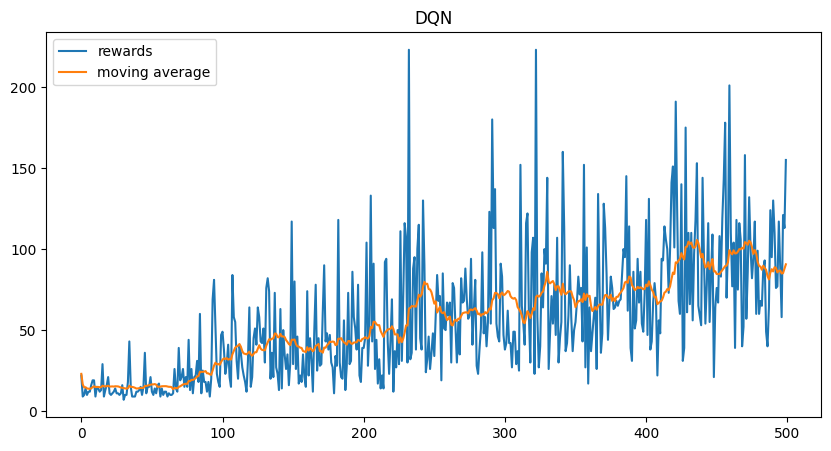

In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("REINFORCE")
plt.show()

ref : https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/12/REINFORCE-CartPole.html

In [ ]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

In [17]:
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps', index=0)

In [58]:
env = gym.make("CartPole-v1")
env.observation_space.seed(0)
env.action_space.seed(0)

print("observation space : ", env.observation_space)
print("action space : ", env.action_space)

observation space :  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space :  Discrete(2)


In [59]:
class Policy(nn.Module):
    def __init__(self,state_size = 4, action_size = 2, hidden_size = 32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state) :
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        
        return F.softmax(x, dim = 1)
    
    def act(self, state) : 
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

In [60]:
def reinforce(policy, optimizer, n_episodes = 1000, max_t = 1000, gamma = 1.0, print_every = 100):
    scores_deque = deque(maxlen = 100)
    scores = []
    for e in range(n_episodes):
        saved_log_probs = []
        rewards = []
        state,_ = env.reset()

        # collect trajectories
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            if done : 
                break

        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discount = [gamma ** i for i in range(len(rewards)+1)]
        R = sum([a*b for a, b in zip(discount, rewards)])

        # Calculate the loss
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)

        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e%print_every == 0:
            print("episode : {}\t Average Score : {:.2f}".format(e, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores


In [63]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
scores = reinforce(policy, optimizer, n_episodes=2000)
torch.save(policy.state_dict(),"./model/reinforce_torch")

episode : 0	 Average Score : 16.00
episode : 100	 Average Score : 28.22
episode : 200	 Average Score : 47.33
episode : 300	 Average Score : 82.70
episode : 400	 Average Score : 72.36
episode : 500	 Average Score : 77.09
episode : 600	 Average Score : 70.83
episode : 700	 Average Score : 59.54
episode : 800	 Average Score : 63.33
episode : 900	 Average Score : 69.09
episode : 1000	 Average Score : 69.71
episode : 1100	 Average Score : 100.43
episode : 1200	 Average Score : 107.08
episode : 1300	 Average Score : 194.76
Environment solved in 1201 episodes!	Average Score: 198.87


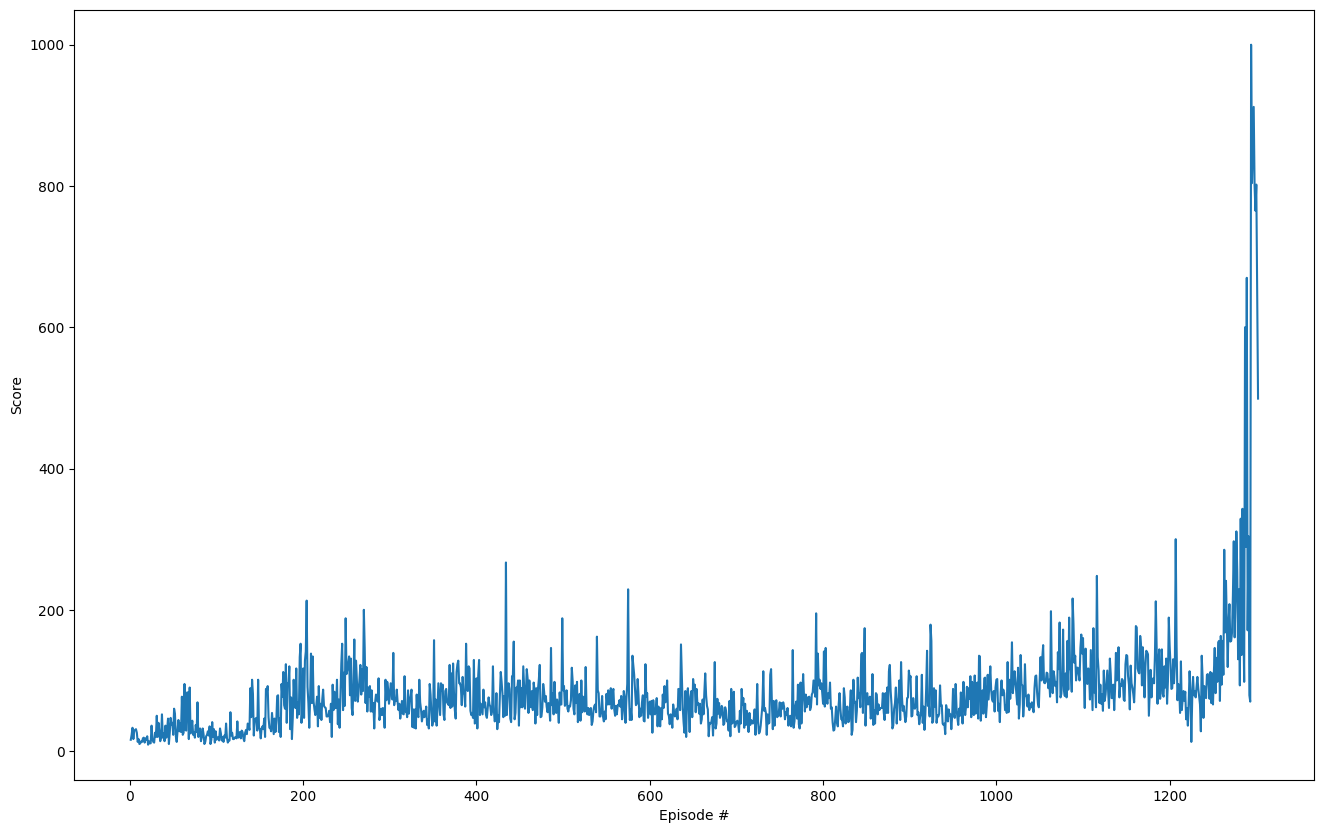

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Advantage Action Critic
=============

In [109]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam, SGD

In [114]:
class Agent(object):
    def __init__(self):
        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1

        self.node_num = 12
        self.learning_rate = 0.002
        self.epoch_cnt = 1
        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()

        self.discount_rate = 0.95
        self.penalty = -100

        self.episode_num = 500

        self.moving_avg_size = 20
        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []

        self.DUMMY_ACTION_MATRIX, self.DUMMY_ADAVANTAGE = np.zeros((1, self.action_size)), np.zeros((1, self.value_size))

    class MyModel(tf.keras.Model):
        def train_step(self, data):
            in_datas, out_action_probs = data
            states, action_matrices, advantages = in_datas[0], in_datas[1], in_datas[2]

            with tf.GradientTape() as tape:
                y_pred = self.call(states, training = True)
                action_probs = K.max(action_matrices*y_pred, axis = -1)
                loss = -K.log(action_probs)*advantages # cost function 
                # cf. REINFOCE : -K.log(action_probs)*rewards
            
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(out_action_probs, y_pred)
            return {m.name: m.result() for m in self.metrics}   
        
    def build_model_actor(self): # policy neural network
        input_states = Input(shape = (self.state_size), name = "input_states")
        input_action_matrices = Input(shape = (self.action_size), name = "input_action_matrices")
        input_advantages = Input(shape = (self.value_size), name = "input_advantages")

        x = (input_states)
        x = Dense(self.node_num, activation = "relu")(x)
        out_actions = Dense(self.action_size, activation = "softmax", name = "output")(x)

        model = self.MyModel(inputs = [input_states, input_action_matrices, input_advantages], outputs = out_actions)
        model.compile(optimizer = Adam(learning_rate = self.learning_rate))
        model.summary()
        return model
    
    def build_model_critic(self): # value neural network
        input_states = Input(shape = (self.state_size), name = "input_states")

        x = (input_states)
        x = Dense(self.node_num, activation = "relu")(x)
        out_values = Dense(self.value_size, activation = "linear", name = "output")(x)

        model = tf.keras.models.Model(inputs = [input_states], outputs = [out_values])
        model.compile(optimizer = Adam(learning_rate = self.learning_rate), loss = 'mean_squared_error')
        model.summary()
        return model
    
    def train(self):
        reward_list = []
        count_list = []
        moving_avg_list = []
        for episode in range(self.episode_num):
            state,_ = self.env.reset()
            self.env.max_episode_step = 500
            count, reward_tot = self.make_memory(episode, state) # 데이터 수집

            if count < 500:
                reward_tot -= self.penalty
            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list, self.moving_avg_size))

            if (episode % 10) == 0:
                print("episode : {}, moving_avg : {}, reward_avg : {}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))

        self.save_model()
    
    def make_memory(self, episode, state):
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False
        while not done:
            count +=1 

            state_t = np.reshape(state, [1, self.state_size])
            action_matrix_t = np.reshape(action_matrix, [1, self.action_size])

            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADAVANTAGE], verbose = 0)
            action = np.random.choice(self.action_size, 1, p = action_prob[0])[0]

            action_matrix = np.zeros(self.action_size)
            action_matrix[action] = 1

            state_next, reward, done, _, _ = self.env.step(action)

            if count < 500 and done : 
                reward = self.penalty

            # 데이터 수집
            self.train_mini_batch(state, state_next, reward, action_matrix, action_prob, done, count)

            state = state_next
            reward_tot += reward

        return count, reward_tot
    
    def train_mini_batch(self, state, state_next, reward, action_matrix, action_prob, done, count) : 
        state_t = np.reshape(state, [1, self.state_size])
        state_next_t = np.reshape(state_next, [1, self.state_size])
        reward_t = np.reshape(reward, [1, self.value_size])
        action_matrix_t = np.reshape(action_matrix, [1, self.action_size])
        action_prob_t = np.reshape(action_prob, [1, self.action_size])

        advatage_t = np.zeros((1, self.value_size))
        target_t = np.zeros((1, self.value_size))

        # value 예측
        value_t = self.model_critic.predict(state_t, verbose = 0)
        value_next_t = self.model_critic.predict(state_next_t, verbose = 0)

        # advantage 및 target 계산
        if(count<500 and done):
            advatage_t = reward_t - value_t
            target_t = reward_t
        else:
            advatage_t = reward_t + self.discount_rate*value_next_t - value_t
            target_t = reward_t + self.discount_rate*value_next_t
        
        # 모델 학습
        self.model_actor.fit(x = [state_t, action_matrix_t, advatage_t], y = [action_prob_t], epochs = self.epoch_cnt, verbose = 0)
        self.model_critic.fit(x = state_t, y = target_t, epochs = self.epoch_cnt, verbose = 0)
    
    def moving_avg(self, data, size = 10):
        if len(data)>10:
            c = np.array(data[len(data) - size : len(data)])
        else:
            c = np.array(data)
        return np.mean(c)
    
    def save_model(self):
        self.model_actor.save("./model/a2c")
        print("****** end learning")


In [115]:
if __name__ == "__main__":
    agent = Agent()
    agent.train()

Model: "my_model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_states (InputLayer)   [(None, 4)]                  0         []                            
                                                                                                  
 dense_29 (Dense)            (None, 12)                   60        ['input_states[0][0]']        
                                                                                                  
 input_action_matrices (Inp  [(None, 2)]                  0         []                            
 utLayer)                                                                                         
                                                                                                  
 input_advantages (InputLay  [(None, 1)]                  0         []                  

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 4)]               0         
                                                                 
 dense_30 (Dense)            (None, 12)                60        
                                                                 
 output (Dense)              (None, 1)                 13        
                                                                 
Total params: 73 (292.00 Byte)
Trainable params: 73 (292.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode : 0, moving_avg : 9.0, reward_avg : 8.0
episode : 10, moving_avg : 15.222222222222221, reward_avg : 13.272727272727273
episode : 20, moving_avg : 17.15, reward_avg : 15.761904761904763
episode : 30, moving_avg : 17.35, reward_avg : 15.258064516129032
episode : 40, moving_avg : 19.85, reward_avg : 17.26829268292683
episode : 50, moving_avg : 20.85, reward_avg : 17.058823529411764
episode : 60, moving_avg : 17.65, reward_avg : 17.065573770491802
episode : 70, moving_avg : 20.65, reward_avg : 17.788732394366196
episode : 80, moving_avg : 22.25, reward_avg : 18.098765432098766
episode : 90, moving_avg : 28.0, reward_avg : 19.813186813186814
episode : 100, moving_avg : 32.55, reward_avg : 20.762376237623762
episode : 110, moving_avg : 42.25, reward_avg : 23.675675675675677
episode : 120, moving_avg : 48.85, reward_avg : 25.239669421487605
episode : 130, moving_avg : 46.3, reward_avg : 26.977099236641223
episode : 140, moving_avg : 40.3, reward_avg : 27.23404255319149
episode : 150, 

INFO:tensorflow:Assets written to: ./model/a2c/assets


****** end learning


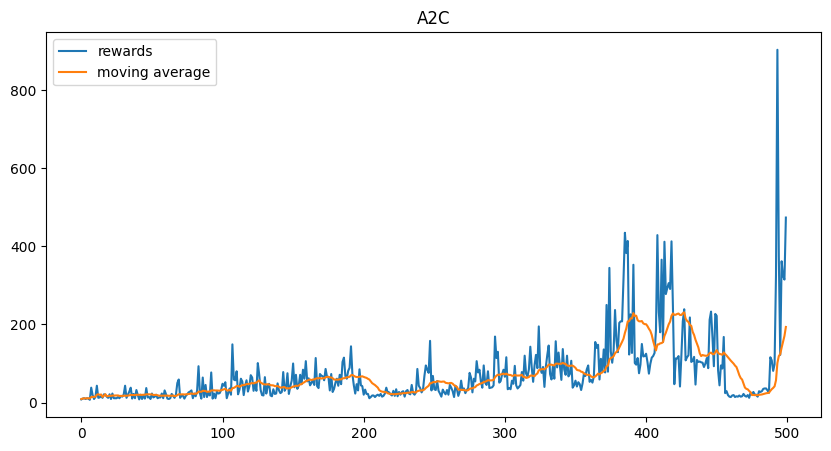

In [117]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("A2C")
plt.show()

PPO
=======

In [137]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
import gym
import numpy as np
import random as rand

LOSS_CLIPPING = 0.1 # clipping 범위 설정

class Agent(object) : 
    def __init__(self):
        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1

        self.node_num = 24
        self.learning_rate_actor = 0.0005
        self.learning_rate_critic = 0.0005
        self.epochs_cnt = 5
        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()

        self.discount_rate = 0.98
        self.smooth_rate = 0.95 # 미래에 받을 보상을 할인하여 계산할 때 발생할 수 있는 분산 감소
        self.penalty = -400

        self.episode_num = 500
        self.mini_batch_step_size = 32

        self.moving_avg_size = 20
        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []

        self.states, self.states_next, self.action_matrices = [],[],[]
        self.dones, self.action_probs, self.rewards = [],[],[]
        self.DUMMY_ACTION_MATRIX = np.zeros((1,1,self.action_size))
        self.DUMMY_ADVANTAGE = np.zeros((1,1,self.value_size))
    
    class MyModel(tf.keras.Model):
        def train_step(self,data):
            in_datas, out_action_probs = data
            states, action_matrices, advantages = in_datas[0], in_datas[1], in_datas[2]
            with tf.GradientTape() as tape:
                y_pred = self.call(states, training = True)
                new_policy = K.max(action_matrices * y_pred, axis = -1) # 신규 정책 확률 -> action_matrix = [1,0] or [0,1]
                old_policy = K.max(action_matrices * out_action_probs, axis = -1)
                r = new_policy/(old_policy)
                clipped = K.clip(r, 1 - LOSS_CLIPPING, 1 + LOSS_CLIPPING)
                loss = -K.minimum(r*advantages, clipped*advantages)

            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(out_action_probs, y_pred)
            return {m.name: m.result() for m in self.metrics}  
    
    def build_model_actor(self):
        input_states = Input(shape = (1, self.state_size), name = "input_states")
        input_action_matrices = Input(shape = (1, self.action_size), name = "input_action_matrices")
        input_advantages = Input(shape = (1, self.value_size), name = "input_advantages")
        x = (input_states)
        x = Dense(self.node_num, activation = 'relu')(x)
        out_actions = Dense(self.action_size, activation = "softmax", name = "output")(x)

        model = self.MyModel(inputs = [input_states, input_action_matrices, input_advantages], outputs = out_actions)
        model.compile(optimizer = Adam(lr = self.learning_rate_actor))

        model.summary()
        return model
    
    def build_model_critic(self):
        input_states = Input(shape = (1,self.state_size), name = "input_states")
        x = (input_states)
        x = Dense(self.node_num, activation = "relu")(x)
        out_values = Dense(self.value_size, activation = "linear", name = "output")(x)

        model = tf.keras.models.Model(inputs = [input_states], outputs = [out_values])
        model.compile(optimizer = Adam(lr = self.learning_rate_critic), loss = "mean_squared_error")

        model.summary()
        return model
    
    def train(self):
        for episode in range(self.episode_num):
            state,_ = self.env.reset()
            self.env.max_episode_steps = 500 # 최대 실행 횟수
            count, reward_tot = self.make_memory(episode, state) # 게임이 종료될 때까지 경험을 수집(train_mini_batch 호출 -> mini_batch_step_size 단위로 나누어서 모델 학습)
            self.train_mini_batch() # 나머지 데이터 학습
            self.clear_memory() # cf. REINFOCE는 하나의 episode가 끝날 때까지 경험을 계속 수집

            if count < 500:
                reward_tot -= self.penalty

            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list, self.moving_avg_size))

            if(episode % 10 == 0):
                print("episode : {}, moving_avg : {}, rewards_avg : {}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))

        self.save_model()
    
    def make_memory(self, episode, state):
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        advantage = np.zeros(self.value_size)
        target = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False

        while not done:
            count += 1
            state_t = np.reshape(state, [1,1,self.state_size])
            action_matrix_t = np.reshape(action_matrix, [1,1,self.action_size])
            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE], verbose = 0)
            
            action = np.random.choice(self.action_size, 1, p = action_prob[0][0])[0]
            action_matrix = np.zeros(self.action_size)
            action_matrix[action] = 1
            state_next, reward, done, _ , _ = self.env.step(action)

            state_next_t = np.reshape(state_next,[1,1,self.state_size])

            if count < 500 and done:
                reward = self.penalty

            self.states.append(np.reshape(state_t, [1,self.state_size]))
            self.states_next.append(np.reshape(state_next_t, [1,self.state_size]))
            self.action_matrices.append(np.reshape(action_matrix, [1,self.action_size]))
            self.dones.append(np.reshape(0 if done else 1, [1,self.value_size])) # 종료 변수 설정
            self.action_probs.append(np.reshape(action_prob, [1, self.action_size]))
            self.rewards.append(np.reshape(reward, [1, self.value_size]))

            if(count % self.mini_batch_step_size == 0): # 모델 학습 : mini_batch_step_size에 의해 설정된 주기로 모델을 학습
                self.train_mini_batch()
                self.clear_memory()
            reward_tot += reward
            state = state_next

        return count, reward_tot
    
    def make_gae(self, values, values_next, rewards, dones):
        delta_adv, delta_tar, adv, target = 0,0,0,0
        advantages = np.zeros(np.array(values).shape)
        targets = np.zeros(np.array(values).shape)
        for t in reversed(range(0,len(rewards))): # 마지막 index부터 반복
            delta_adv = rewards[t] + self.discount_rate * values_next[t] * dones[t] - values[t] # dones는 게임이 종료된 경우 values_next의 영향을 고려하지 않기 위해 도입
            delta_tar = rewards[t] + self.discount_rate*values_next[t]*dones[t]
            adv = delta_adv + self.smooth_rate*self.discount_rate*dones[t]*adv
            target = delta_tar + self.smooth_rate*self.discount_rate*dones[t]*target
            advantages[t] = adv
            targets[t] = target
        return advantages, targets
    
    def train_mini_batch(self):
        if len(self.states) == 0:
            return
        
        states_t = np.array(self.states)
        states_next_t = np.array(self.states_next)
        action_matrices_t = np.array(self.action_matrices)
        action_probs_t = np.array(self.action_probs)
        rewards_t = np.array(self.rewards)

        # 가치 예측
        values = self.model_critic.predict(states_t, verbose = 0)
        values_next = self.model_critic.predict(states_next_t, verbose = 0)
        
        # GAE 계산
        advantages, targets = self.make_gae(values, values_next, self.rewards, self.dones)
        advantages_t = np.array(advantages)
        targets_t = np.array(targets)

        self.model_actor.fit([states_t, action_matrices_t, advantages_t],[action_probs_t], epochs = self.epochs_cnt, verbose = 0)
        self.model_critic.fit(states_t, targets_t, epochs = self.epochs_cnt, verbose = 0)

    def clear_memory(self):
        self.states, self.states_next, self.action_matrices = [],[],[]
        self.dones, self.action_probs, self.rewards = [],[],[]

    def moving_avg(self, data, size = 10):
        if len(data) > size : 
            c = np.array(data[len(data) - size : len(data)])
        else:
            c = np.array(data)
        return np.mean(c)
    
    def save_model(self):
        self.model_actor.save("./model/ppo")
        print("*****end learning")

if __name__ == "__main__":
    agent = Agent()
    agent.train()

            

Model: "my_model_36"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_states (InputLayer)   [(None, 1, 4)]               0         []                            
                                                                                                  
 dense_47 (Dense)            (None, 1, 24)                120       ['input_states[0][0]']        
                                                                                                  
 input_action_matrices (Inp  [(None, 1, 2)]               0         []                            
 utLayer)                                                                                         
                                                                                                  
 input_advantages (InputLay  [(None, 1, 1)]               0         []                  

/opt/homebrew/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode : 0, moving_avg : 24.0, rewards_avg : 23.0
episode : 10, moving_avg : 23.818181818181817, rewards_avg : 22.818181818181817
episode : 20, moving_avg : 22.05, rewards_avg : 21.142857142857142
episode : 30, moving_avg : 18.45, rewards_avg : 19.35483870967742
episode : 40, moving_avg : 18.75, rewards_avg : 19.48780487804878
episode : 50, moving_avg : 26.85, rewards_avg : 21.901960784313726
episode : 60, moving_avg : 27.6, rewards_avg : 21.81967213114754
episode : 70, moving_avg : 23.4, rewards_avg : 22.04225352112676
episode : 80, moving_avg : 24.05, rewards_avg : 22.123456790123456
episode : 90, moving_avg : 21.25, rewards_avg : 21.64835164835165
episode : 100, moving_avg : 22.4, rewards_avg : 21.980198019801982
episode : 110, moving_avg : 22.5, rewards_avg : 21.62162162162162
episode : 120, moving_avg : 17.8, rewards_avg : 21.123966942148762
episode : 130, moving_avg : 19.0, rewards_avg : 21.068702290076335
episode : 140, moving_avg : 22.2, rewards_avg : 21.134751773049647
episod

INFO:tensorflow:Assets written to: ./model/ppo/assets


*****end learning


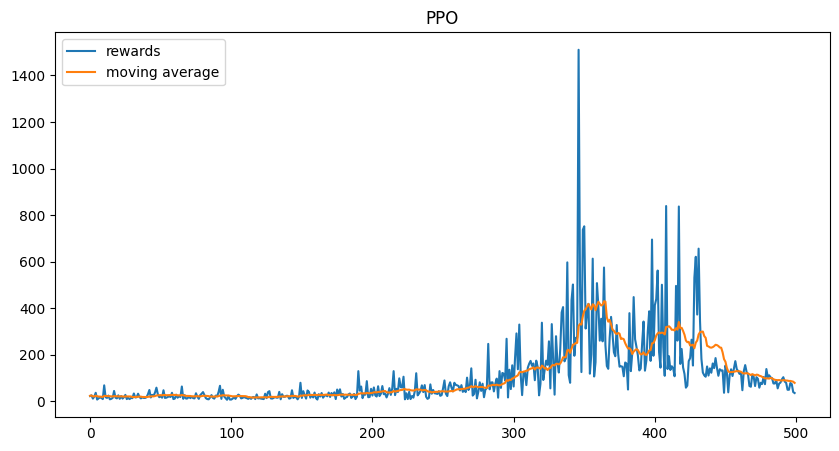

In [138]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("PPO")
plt.show()

PPO Fine tuning
=====

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
import gym
import numpy as np
import random

In [3]:
LOSS_CLIPPING = 0.2
class Agent(object):
    def __init__(self):
        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1
        self.node_num = 24
        self.learning_rate_actor = 0.0005
        self.learning_rate_critic = 0.0005
        self.epochs_cnt = 5
        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()

        self.discount_rate = 0.98
        self.smooth_rate = 0.95
        self.penalty = -400

        self.episode_num = 500
        self.mini_batch_step_size = 32

        self.moving_avg_size = 20
        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []

        self.states, self.states_next, self.action_matrices = [],[],[]
        self.dones, self.action_probs, self.rewards = [],[],[]
        self.DUMMY_ACTION_MATRIX = np.zeros((1,1,self.action_size))
        self.DUMMY_ADVANTAGE = np.zeros((1,1,self.value_size))

    class MyModel(tf.keras.Model):
        def train_step(self, data):
            in_datas, out_action_probs = data
            states, action_matrices, advantages = in_datas[0], in_datas[1], in_datas[2]
            with tf.GradientTape() as tape:
                y_pred = self.call(states, training = True)
                new_policy = K.max(action_matrices * y_pred, axis = -1)
                old_policy = K.max(action_matrices * out_action_probs, axis = -1)
                r = new_policy/(old_policy)
                clipped = K.clip(r, 1-LOSS_CLIPPING, 1+LOSS_CLIPPING)
                loss = -K.minimum(r*advantages, clipped*advantages)
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(out_action_probs, y_pred)
            return {m.name: m.result() for m in self.metrics}  
        
    def build_model_actor(self):
        input_states = Input(shape = (1,self.state_size), name = "input_states")
        input_action_matrices = Input(shape = (1,self.action_size), name = "input_action_matrices")
        input_advantages = Input(shape = (1,self.value_size), name = "input_advantages")
        x = (input_states)
        x = Dense(self.node_num, activation = "relu", kernel_initializer = "glorot_normal")(x)
        out_actions = Dense(self.action_size, activation = "softmax", name = "output")(x)
        model = self.MyModel(inputs = [input_states, input_action_matrices, input_advantages], outputs = out_actions)
        model.compile(optimizer = Adam(learning_rate=self.learning_rate_actor))
        model.summary()
        return model
    
    def build_model_critic(self):
        input_states = Input(shape = (1, self.state_size), name = "input_states")
        x = (input_states)
        x = Dense(self.node_num, activation = "relu", kernel_initializer = "glorot_normal")(x)
        out_values = Dense(self.value_size, activation = "linear", name = "output")(x)
        model = tf.keras.models.Model(inputs = [input_states], outputs = [out_values])
        model.compile(optimizer = Adam(learning_rate = self.learning_rate_critic), loss = "mean_squared_error")
        model.summary()
        return model
    
    def train(self):
        for episode in range(self.episode_num):
            state,_ = self.env.reset()
            self.env.max_episode_steps = 500
            count, reward_tot = self.make_memory(episode, state)
            self.train_mini_batch()
            self.clear_memory()

            if count < 500:
                reward_tot -= self.penalty
            
            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list,self.moving_avg_size))

            if(episode % 10 == 0 ):
                print("episode : {}, moving_avg : {}, rewards_avg : {}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))
        self.save_model()

    def moving_avg(self, data, size = 10):
        if len(data)>size : 
            c = np.array(data[len(data) - size : len(data)])
        else:
            c = np.array(data)
        return np.mean(c)
    
    def clear_memory(self):
        self.states, self.states_next, self.action_matrices = [],[],[]
        self.dones, self.action_probs, self.rewards = [],[],[]

    def make_memory(self, episode, state):
        reward_tot, count = 0,0
        reward, advantage, target, action_matrix = np.zeros(self.value_size),np.zeros(self.value_size),np.zeros(self.value_size), np.zeros(self.action_size)
        done = False

        while not done:
            count+=1
            state_t =  np.reshape(self.normalize(state), [1,1,self.state_size])
            action_matrix_t = np.reshape(action_matrix, [1,1, self.action_size])
            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE], verbose = 0)
            action = np.random.choice(self.action_size, 1, p = action_prob[0][0])[0]
            action_matrix = np.zeros(self.action_size)
            action_matrix[action] = 1
            state_next, reward, done, _, _ = self.env.step(action)
            state_next_t = np.reshape(self.normalize(state_next), [1,1,self.state_size])

            if count < 500 and done:
                reward = self.penalty
            
            self.states.append(np.reshape(state_t, [1,self.state_size]))
            self.states_next.append(np.reshape(state_next_t, [1,self.state_size]))
            self.action_matrices.append(np.reshape(action_matrix,[1, self.action_size]))
            self.dones.append(np.reshape(0 if done else 1, [1, self.value_size]))
            self.action_probs.append(np.reshape(action_prob, [1, self.action_size]))
            self.rewards.append(np.reshape(reward, [1,self.value_size]))

            if (count % self.mini_batch_step_size == 0):
                self.train_mini_batch()
                self.clear_memory()
            reward_tot += reward
            state = state_next

        return count, reward_tot

    def make_gae(self, values, values_next, rewards, dones):
        delta_adv, delta_tar, adv, target = 0,0,0,0
        advantages = np.zeros(np.array(values).shape)
        targets = np.zeros(np.array(values).shape)
        for t in reversed(range(0,len(rewards))):
            delta_adv = rewards[t] + self.discount_rate*values_next[t]*dones[t] - values[t]
            delta_tar = rewards[t] + self.discount_rate*values_next[t]*dones[t]
            adv = delta_adv + self.smooth_rate*self.discount_rate*dones[t]*adv
            target = delta_tar + self.smooth_rate*self.discount_rate*dones[t]*target
            advantages[t] = adv
            targets[t] = target

        return advantages, targets
    
    def normalize(self, x):
        norm = np.linalg.norm(x)
        if norm == 0 :
            return x
        return x / norm
    
    def train_mini_batch(self):
        if len(self.states) == 0:
            return
        states_t = np.array(self.states)
        states_next_t = np.array(self.states_next)
        action_matrices_t = np.array(self.action_matrices)
        action_probs_t = np.array(self.action_probs)
        rewards_t = np.array(self.rewards)
        values = self.model_critic.predict(states_t, verbose = 0)
        values_next = self.model_critic.predict(states_next_t, verbose = 0)

        advantages, targets = self.make_gae(values, values_next, self.rewards, self.dones)
        advantages_t = np.array(advantages)
        targets_t = np.array(targets)
        self.model_actor.fit([states_t, action_matrices_t, advantages_t], [action_probs_t], epochs = self.epochs_cnt, verbose = 0)
        self.model_critic.fit(states_t, targets_t, epochs = self.epochs_cnt, verbose = 0)

    def save_model(self):
        self.model_actor.save("./model/ppo_tuned")
        print("*****end learning")

if __name__ == "__main__":
    agent = Agent()
    agent.train()


Model: "my_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_states (InputLayer)   [(None, 1, 4)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 1, 24)                120       ['input_states[0][0]']        
                                                                                                  
 input_action_matrices (Inp  [(None, 1, 2)]               0         []                            
 utLayer)                                                                                         
                                                                                                  
 input_advantages (InputLay  [(None, 1, 1)]               0         []                     

/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode : 0, moving_avg : 19.0, rewards_avg : 18.0
episode : 10, moving_avg : 38.81818181818182, rewards_avg : 37.81818181818182
episode : 20, moving_avg : 43.85, rewards_avg : 41.666666666666664
episode : 30, moving_avg : 55.05, rewards_avg : 48.29032258064516
episode : 40, moving_avg : 75.05, rewards_avg : 57.46341463414634
episode : 50, moving_avg : 81.25, rewards_avg : 60.8235294117647
episode : 60, moving_avg : 78.35, rewards_avg : 63.98360655737705
episode : 70, moving_avg : 93.05, rewards_avg : 69.61971830985915
episode : 80, moving_avg : 92.7, rewards_avg : 70.82716049382717
episode : 90, moving_avg : 101.1, rewards_avg : 76.31868131868131
episode : 100, moving_avg : 123.5, rewards_avg : 81.05940594059406
episode : 110, moving_avg : 146.55, rewards_avg : 88.7927927927928
episode : 120, moving_avg : 175.15, rewards_avg : 96.44628099173553
episode : 130, moving_avg : 195.15, rewards_avg : 104.87786259541984
episode : 140, moving_avg : 252.45, rewards_avg : 118.43262411347517
epis

INFO:tensorflow:Assets written to: ./model/ppo_tuned/assets


*****end learning


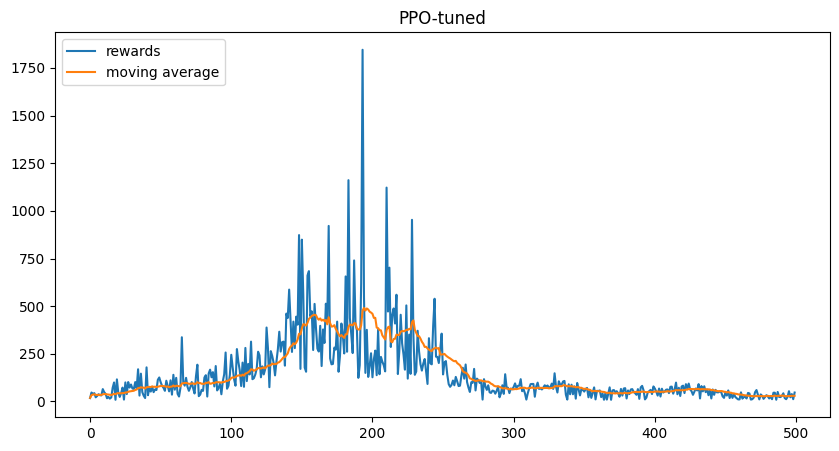

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("PPO-tuned")
plt.show()

PPO with Grid Search
============

In [45]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import gym
import numpy as np
import random as rand

class Agent(object):
    def __init__(self, config_data):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1
        
        self.layer_num_actor = config_data['layer_num_actor']
        self.node_num_actor = config_data['node_num_actor']
        self.epochs_actor = config_data['epochs_actor']
        self.layer_num_critic = config_data['layer_num_critic']
        self.node_num_critic = config_data['node_num_critic']
        self.epochs_critic = config_data['epochs_critic']
        
        self.learning_rate_actor = config_data['learning_rate_actor']
        self.learning_rate_critic = config_data['learning_rate_critic']
        self.discount_rate = config_data['discount_rate']
        self.smooth_rate = config_data['smooth_rate']
        self.penalty = config_data['penalty']
        self.mini_batch_step_size = config_data['mini_batch_step_size']
        self.loss_clipping = config_data['loss_clipping']

        self.episode_num = 200
        self.moving_avg_size = 20
        
        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()
 
        self.states, self.states_next, self.action_matrixs, self.dones, self.action_probs, self.rewards = [],[],[],[],[],[]
        self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE, self.DUMMY_LOSS_CLIPPING = np.zeros((1,1,self.action_size)), np.zeros((1,1,self.value_size)), np.zeros((1,1,self.value_size))
    
        self.reward_list= []
        self.count_list = []
        self.moving_avg_list = []
        
    class MyModel(tf.keras.Model):
        def train_step(self, data):
            in_datas, out_action_probs = data
            states, action_matrixs, advantages, loss_clipping = in_datas[0], in_datas[1], in_datas[2], in_datas[3]

            with tf.GradientTape() as tape:
                y_pred = self(states, training=True)
                new_policy = K.max(action_matrixs*y_pred, axis=-1)   
                old_policy = K.max(action_matrixs*out_action_probs, axis=-1)    
                r = new_policy/(old_policy)
                
                LOSS_CLIPPING = K.mean(loss_clipping)
                
                loss = -K.minimum(r*advantages, K.clip(r, 1-LOSS_CLIPPING, 1+LOSS_CLIPPING)*advantages)
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(out_action_probs, y_pred)
            return {m.name: m.result() for m in self.metrics}  
            
    def build_model_actor(self):
        input_states = Input(shape=(1,self.state_size), name='input_states')
        input_action_matrixs = Input(shape=(1,self.action_size), name='input_action_matrixs')
        input_advantages = Input(shape=(1,self.value_size), name='input_advantages')
        input_loss_clipping = Input(shape=(1,self.value_size), name='input_loss_clipping')        
        
        x = (input_states)
        for i in range(1,self.layer_num_actor+1):            
            x = Dense(self.node_num_actor, activation="relu", kernel_initializer='glorot_normal')(x)
        out_actions = Dense(self.action_size, activation='softmax', name='output')(x)
        
        model = self.MyModel(inputs=[input_states, input_action_matrixs, input_advantages, input_loss_clipping],
                             outputs=out_actions)
        model.compile(optimizer=Adam(lr=self.learning_rate_actor))
        
        return model
    
    def build_model_critic(self):
        input_states = Input(shape=(1,self.state_size), name='input_states')
        
        x = (input_states)
        for i in range(1,self.layer_num_critic+1):
            x = Dense(self.node_num_critic, activation="relu", kernel_initializer='glorot_normal')(x)
        out_values = Dense(self.value_size, activation='linear', name='output')(x)
        
        model = tf.keras.models.Model(inputs=[input_states], outputs=[out_values])
        model.compile(optimizer=Adam(lr=self.learning_rate_critic),
#                       loss='mean_squared_error'
                      loss = "binary_crossentropy"
                     )
        return model

    def train(self):
        for episode in range(self.episode_num):

            state = self.env.reset()
            state = state[0]

            count, reward_tot = self.make_memory(episode, state)
            self.train_mini_batch()
            self.clear_memory()
            
            if count < 500:
                reward_tot = reward_tot-self.penalty
            
            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list,self.moving_avg_size))                
            

    def moving_avg(self, data, size=10):
        if len(data) > size:
            c = np.array(data[len(data)-size:len(data)]) 
        else:
            c = np.array(data) 
        return np.mean(c)
    
    def clear_memory(self):
        self.states, self.states_next, self.action_matrixs, self.done, self.action_probs, self.rewards = [],[],[],[],[],[]
        
    def make_memory(self, episode, state):
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        advantage = np.zeros(self.value_size)
        target = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False
        
        while not done:
            count+=1

            state_t = np.reshape(self.normalize(state),[1, 1, self.state_size])
            action_matrix_t = np.reshape(action_matrix,[1, 1, self.action_size])
            
            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE. self.DUMMY_LOSS_CLIPPING])
            action = np.random.choice(self.action_size, 1, p=action_prob[0][0])[0]
            action_matrix = np.zeros(self.action_size) #초기화
            action_matrix[action] = 1

            state_next, reward, done, none, none2 = self.env.step(action)
            
            state_next_t = np.reshape(self.normalize(state_next),[1, 1, self.state_size])
            
            if count < 500 and done:
                reward = self.penalty 
        
            self.states.append(np.reshape(state_t, [1,self.state_size]))
            self.states_next.append(np.reshape(state_next_t, [1,self.state_size]))
            self.action_matrixs.append(np.reshape(action_matrix, [1,self.action_size]))
            self.dones.append(np.reshape(0 if done else 1, [1,self.value_size]))
            self.action_probs.append(np.reshape(action_prob, [1,self.action_size]))
            self.rewards.append(np.reshape(reward, [1,self.value_size]))
            
            if(count % self.mini_batch_step_size == 0):
                self.train_mini_batch()
                self.clear_memory()

            reward_tot += reward
            state = state_next
            
        return count, reward_tot
    
    def make_gae(self, values, values_next, rewards, dones):
        delta_adv, delta_tar, adv, target = 0, 0, 0, 0
        advantages = np.zeros(np.array(values).shape)
        targets = np.zeros(np.array(values).shape)
        for t in reversed(range(0, len(rewards))):
            delta_adv = rewards[t] + self.discount_rate * values_next[t] * dones[t] - values[t]
            delta_tar = rewards[t] + self.discount_rate * values_next[t] * dones[t]
            adv = delta_adv + self.smooth_rate *  self.discount_rate * dones[t] * adv
            target = delta_tar + self.smooth_rate * self.discount_rate * dones[t] * target
            advantages[t] = adv
            targets[t] = target
        return advantages, targets

    def normalize(self, x):
        norm = np.linalg.norm(x)
        if norm == 0: 
            return x
        return x / norm

    def train_mini_batch(self):
        
        if len(self.states) == 0:
            return
        
        states_t = np.array(self.states)
        states_next_t = np.array(self.states_next)
        action_matrixs_t = np.array(self.action_matrixs)
        action_probs_t = np.array(self.action_probs)
        loss_clipping = [self.loss_clipping for j in range(len(self.states))]
        loss_clipping_t = np.reshape(loss_clipping, [len(self.states),1,1])
        
        values = self.model_critic.predict(states_t)
        values_next = self.model_critic.predict(states_next_t)
        
        advantages, targets = self.make_gae(values, values_next, self.rewards, self.dones)
        advantages_t = np.array(advantages)
        targets_t = np.array(targets)
        
        self.model_actor.fit([states_t, action_matrixs_t, advantages_t, loss_clipping_t], [action_probs_t], 
                             epochs=self.epochs_actor, verbose=0)
        self.model_critic.fit(states_t, targets_t, 
                              epochs=self.epochs_critic, verbose=0)       
        

if __name__ == "__main__":

    def random_select():
        config_data = {
            'layer_num_actor':rand.randint(1,2),
            'node_num_actor':rand.randint(12,128),
            'epochs_actor':rand.randint(3,6),
            'layer_num_critic':rand.randint(1,2),
            'node_num_critic':rand.randint(12,128),
            'epochs_critic':rand.randint(3,6),
            
            'learning_rate_actor' :rand.uniform(0.0001,0.001),
            'learning_rate_critic':rand.uniform(0.0001,0.001),
            'discount_rate'       :rand.uniform(0.9,0.99),
            'smooth_rate'       :rand.uniform(0.9,0.99),
            'penalty'             :rand.randint(-500,-10),
            'mini_batch_step_size':rand.randint(4,80),
            'loss_clipping'       :rand.uniform(0.1,0.3)
        }
        return config_data

    results = []
    print("***** start random search *****")        
    for i in range(10):
        config_data = random_select()
        agent = Agent(config_data)
        print("*config:", config_data)
        agent.train()
        result = []
        result.append(config_data)
        result.append(agent.moving_avg_list[len(agent.moving_avg_list)-1])
        result.append(np.mean(agent.reward_list))
        results.append(result)
        print("*result:", i, agent.moving_avg_list[len(agent.moving_avg_list)-1], np.mean(agent.reward_list))
        print("-"*100)
    print("***** end random search *****")    
    

***** start random search *****
*config: {'layer_num_actor': 1, 'node_num_actor': 57, 'epochs_actor': 3, 'layer_num_critic': 1, 'node_num_critic': 115, 'epochs_critic': 6, 'learning_rate_actor': 0.0008824594273730204, 'learning_rate_critic': 0.0007182146959379878, 'discount_rate': 0.9753413068667055, 'smooth_rate': 0.9009303028742445, 'penalty': -274, 'mini_batch_step_size': 5, 'loss_clipping': 0.20961734161319573}


ValueError: in user code:

    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "my_model_304" expects 4 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 1, 4) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1, 2) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1, 1) dtype=float32>]


In [24]:
avg_list = []
for i in range(0,50):
    avg_list.append([results[i][2],i])
avg_list.sort(reverse=True)
avg_list

[[23.26, 46],
 [22.435, 15],
 [22.335, 4],
 [22.19, 24],
 [22.11, 13],
 [22.085, 47],
 [22.005, 28],
 [22.005, 1],
 [21.96, 25],
 [21.92, 44],
 [21.865, 10],
 [21.775, 36],
 [21.775, 35],
 [21.77, 31],
 [21.75, 41],
 [21.69, 43],
 [21.475, 16],
 [21.46, 33],
 [21.435, 21],
 [21.415, 5],
 [21.39, 23],
 [21.365, 18],
 [21.35, 37],
 [21.22, 11],
 [21.215, 42],
 [21.195, 14],
 [21.17, 48],
 [21.16, 22],
 [21.095, 6],
 [21.07, 2],
 [21.005, 7],
 [21.005, 3],
 [20.85, 12],
 [20.8, 9],
 [20.775, 32],
 [20.7, 19],
 [20.59, 27],
 [20.57, 39],
 [20.56, 20],
 [20.55, 45],
 [20.385, 40],
 [20.34, 30],
 [20.28, 0],
 [20.17, 29],
 [20.075, 8],
 [19.895, 49],
 [19.875, 34],
 [19.22, 26],
 [16.62, 17],
 [14.93, 38]]

In [28]:
best_config = results[46][0]
results[46]

[{'layer_num_actor': 1,
  'node_num_actor': 73,
  'epochs_actor': 3,
  'layer_num_critic': 1,
  'node_num_critic': 13,
  'epochs_critic': 6,
  'learning_rate_actor': 0.00030455884507925556,
  'learning_rate_critic': 0.0005824343831420121,
  'discount_rate': 0.9448292737105757,
  'smooth_rate': 0.9011013445145203,
  'penalty': -193,
  'mini_batch_step_size': 73,
  'loss_clipping': 0.12209971714397201},
 25.3,
 23.26]

In [29]:
best_config

{'layer_num_actor': 1,
 'node_num_actor': 73,
 'epochs_actor': 3,
 'layer_num_critic': 1,
 'node_num_critic': 13,
 'epochs_critic': 6,
 'learning_rate_actor': 0.00030455884507925556,
 'learning_rate_critic': 0.0005824343831420121,
 'discount_rate': 0.9448292737105757,
 'smooth_rate': 0.9011013445145203,
 'penalty': -193,
 'mini_batch_step_size': 73,
 'loss_clipping': 0.12209971714397201}

In [44]:
LOSS_CLIPPING = 0.12209971714397201
class Agent(object):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1

        self.layer_num_actor = 1
        self.node_num_actor = 73
        self.epochs_actor = 3
        self.layer_num_critic = 1
        self.node_num_critic = 13
        self.epochs_critic = 6
        
        self.learning_rate_actor = 0.00030455884507925556
        self.learning_rate_critic = 0.0005824343831420121
        self.discount_rate = 0.9448292737105757
        self.smooth_rate = 0.9011013445145203
        self.penalty = -193
        self.mini_batch_step_size = 73
   
        self.episode_num = 300
        
        self.moving_avg_size = 20
        
        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()
 
        self.states, self.states_next, self.action_matrices, self.dones, self.action_probs, self.rewards = [],[],[],[],[],[]
        self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE= np.zeros((1,1,self.action_size)), np.zeros((1,1,self.value_size))
        self.DUMMY_LOSS_CLIPPING = np.zeros((1,1,self.value_size))

        self.reward_list= []
        self.count_list = []
        self.moving_avg_list = []
        
    class MyModel(tf.keras.Model):
        def train_step(self,data):
            in_datas, out_action_probs = data
            states, action_matrices, advatages = in_datas[0], in_datas[1], in_datas[2],
            with tf.GradientTape() as tape : 
                y_pred = self.call(states, training = True)
                new_policy = K.max(action_matrices * y_pred, axis = -1)
                old_policy = K.max(action_matrices * out_action_probs, axis = -1)
                r = new_policy/(old_policy)
                loss = -K.minimum(r*advatages, K.clip(r, 1-LOSS_CLIPPING, 1+LOSS_CLIPPING) * advatages)
            
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(out_action_probs, y_pred)
            return {m.name: m.result() for m in self.metrics}  
    
    def build_model_actor(self):
        input_states = Input(shape = (1, self.state_size), name = "input_states")
        input_action_matrices = Input(shape = (1,self.action_size), name = "input_action_matrices")
        input_advantages = Input(shape= (1, self.value_size), name = "input_advantages")

        x = (input_states)
        for i in range(1, self.layer_num_actor + 1) : 
            x = Dense(self.node_num_actor, activation = "relu", kernel_initializer = "glorot_normal")(x)
        out_actions = Dense(self.action_size, activation = "softmax", name = "output")(x)

        model = self.MyModel(inputs = [input_states, input_action_matrices, input_advantages], outputs = out_actions)
        model.compile(optimizer = Adam(learning_rate = self.learning_rate_actor))
        return model
    
    def build_model_critic(self):
        input_states = Input(shape = (1,self.state_size), name = "input_states")
        x = (input_states)
        for i in range(1, self.layer_num_critic + 1) : 
            x = Dense(self.node_num_critic, activation = "relu", kernel_initializer = "glorot_normal")(x)
        out_values = Dense(self.value_size, activation = "linear", name = "output")(x)
        model = tf.keras.models.Model(inputs = [input_states], outputs = [out_values])
        model.compile(optimizer = Adam(learning_rate = self.learning_rate_critic), loss = "binary_crossentropy")

        return model
    
    def train(self):
        for episode in range(self.episode_num):
            state,_ = self.env.reset()
            count, reward_tot = self.make_memory(episode, state)
            self.train_mini_batch()
            self.clear_memory()

            if count < 500:
                reward_tot -= self.penalty

            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list, self.moving_avg_size))
            if(episode % 10 == 0):
                print("episode:{}, moving_avg:{}, rewards_avg:{}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))
        self.save_model()

    def moving_avg(self, data, size = 10):
        if len(data)>size:
            c = np.array(data[len(data) - size : len(data)])
        else:
            c = np.array(data)
        return np.mean(c)
    
    def clear_memory(self):
        self.states, self.states_next, self.action_matrices, self.dones = [],[],[],[]
        self.action_probs, self.rewards = [],[]

    def make_memory(self, episode, state):
        reward_tot, count = 0,0
        reward, advantage, target = np.zeros(self.value_size),np.zeros(self.value_size),np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False

        while not done:
            count+=1
            state_t = np.reshape(self.normalize(state), [1,1,self.state_size])
            action_matrix_t = np.reshape(self.normalize(action_matrix),[1,1,self.action_size])
            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE],verbose = 0)
            action = np.random.choice(self.action_size, 1, p = action_prob[0][0])[0]
            action_matrix = np.zeros(self.action_size)
            action_matrix[action] = 1
            state_next, reward, done, _, _ = self.env.step(action)

            state_next_t = np.reshape(self.normalize(state_next), [1,1,self.state_size])

            if count<500 and done:
                reward = self.penalty

            self.states.append(np.reshape(state_t, [1, self.state_size]))
            self.states_next.append(np.reshape(state_next_t, [1,self.state_size]))
            self.action_matrices.append(np.reshape(action_matrix, [1, self.action_size]))
            self.dones.append(np.reshape(0 if done else 1, [1,self.value_size]))
            self.action_probs.append(np.reshape(action_prob, [1, self.action_size]))
            self.rewards.append(np.reshape(reward, [1, self.value_size]))

            if(count%self.mini_batch_step_size == 0):
                self.train_mini_batch()
                self.clear_memory()
            reward_tot += reward
            state = state_next
        return count, reward_tot
    
    def make_gae(self, values, values_next, rewards, dones):
        delta_adv, delta_tar, adv, target = 0,0,0,0
        advantages = np.zeros(np.array(values).shape)
        targets = np.zeros(np.array(values).shape)
        for t in reversed(range(0,len(rewards))):
            delta_adv = rewards[t] + self.discount_rate*values_next[t]*dones[t]-values[t]
            delta_tar = rewards[t] + self.discount_rate*values_next[t]*dones[t]
            adv = delta_adv + self.smooth_rate * self.discount_rate * self.dones[t] * adv
            target = delta_tar + self.smooth_rate*self.discount_rate*self.dones[t]*target
            advantages[t] = adv
            targets[t] = target
        return advantages, targets
    
    def normalize(self, x):
        norm = np.linalg.norm(x)
        if norm == 0 :
            return x
        return x/norm
    
    def train_mini_batch(self):
            
            if len(self.states) == 0:
                return
            
            states_t = np.array(self.states)
            states_next_t = np.array(self.states_next)
            action_matrices_t = np.array(self.action_matrices)
            action_probs_t = np.array(self.action_probs)
            rewards_t = np.array(self.rewards)

            values = self.model_critic.predict(states_t,verbose = 0)
            values_next = self.model_critic.predict(states_next_t,verbose = 0)
            
            advantages, targets = self.make_gae(values, values_next, self.rewards, self.dones)
            advantages_t = np.array(advantages)
            targets_t = np.array(targets)

            self.model_actor.fit([states_t, action_matrices_t, advantages_t], [action_probs_t], epochs=5, verbose=0)
            self.model_critic.fit(states_t, targets_t, epochs=5, verbose=0) 

    def save_model(self):
        self.model_actor.save("./model/ppo_tuned_grid")
        print("*****end learing")

if __name__ == "__main__":
    agent = Agent()
    agent.train()

/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode:0, moving_avg:21.0, rewards_avg:20.0
episode:10, moving_avg:22.545454545454547, rewards_avg:21.545454545454547
episode:20, moving_avg:24.45, rewards_avg:23.285714285714285
episode:30, moving_avg:22.35, rewards_avg:21.419354838709676
episode:40, moving_avg:20.8, rewards_avg:21.585365853658537
episode:50, moving_avg:23.35, rewards_avg:21.784313725490197
episode:60, moving_avg:22.4, rewards_avg:21.524590163934427
episode:70, moving_avg:21.9, rewards_avg:21.535211267605632
episode:80, moving_avg:23.45, rewards_avg:21.753086419753085
episode:90, moving_avg:27.8, rewards_avg:22.692307692307693
episode:100, moving_avg:34.1, rewards_avg:24.0
episode:110, moving_avg:40.2, rewards_avg:25.666666666666668
episode:120, moving_avg:64.55, rewards_avg:30.537190082644628
episode:130, moving_avg:85.2, rewards_avg:34.603053435114504
episode:140, moving_avg:75.85, rewards_avg:36.822695035460995
episode:150, moving_avg:65.75, rewards_avg:38.59602649006622
episode:160, moving_avg:75.9, rewards_avg:4

KeyboardInterrupt: 

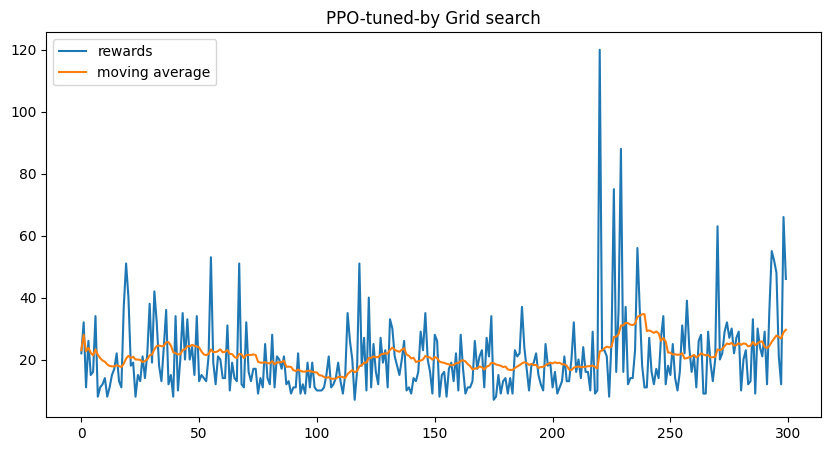

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("PPO-tuned-by Grid search")
plt.show()